In [73]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Nov__3_17:16:49_PDT_2023
Cuda compilation tools, release 12.3, V12.3.103
Build cuda_12.3.r12.3/compiler.33492891_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
from glob import glob

import detectron2

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg

from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode, Visualizer

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

import random
from detectron2.utils.visualizer import ColorMode, Visualizer
from PIL import Image
from glob import glob
import os 

from detectron2.utils.visualizer import ColorMode, Visualizer
setup_logger()

import os, json, random

In [75]:
def pixel_accuracy(ground_truth, prediction):
    assert ground_truth.shape == prediction.shape, "Ground truth and prediction must have the same shape"

    correct_pixels = np.sum(ground_truth == prediction)
    total_pixels = ground_truth.size

    accuracy = correct_pixels / total_pixels
    return accuracy

In [76]:
def positive_class_accuracy(ground_truth, prediction):
    assert ground_truth.shape == prediction.shape, "Ground truth and prediction must have the same shape"

    # Identify pixels where the ground truth is 1
    gt_positive_pixels = ground_truth == 1

    # Count correctly predicted positive pixels
    correct_positive_predictions = np.sum(prediction[gt_positive_pixels] == 1)

    # Total number of positive pixels in ground truth
    total_positive_pixels = np.sum(gt_positive_pixels)

    if total_positive_pixels == 0:
        return 1.0  # Or handle this special case differently if preferred

    accuracy = correct_positive_predictions / total_positive_pixels
    return accuracy

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = "best_model_bench.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[03/08 20:56:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_0002999.pth ...


In [ ]:
city = "Chicago"
furniture = "bollard"

register_coco_instances("test", {}, f"ThreeCitiesVal/gt/{city}_{furniture}.v1i.coco/_annotations.coco.json", "")
datasetdict = DatasetCatalog.get("test")

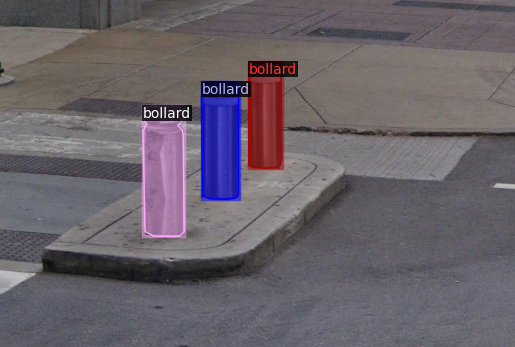

In [ ]:
mpl.rcParams['savefig.pad_inches'] = 0
bench_metadata = MetadataCatalog.get("test")

img = cv2.imread(f"ThreeCitiesVal/gt/{city}_{furniture}.v1i.coco/" + d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=bench_metadata, scale=0.5)
vis = visualizer.draw_dataset_dict(d)

img = vis.get_image()[:, :, ::-1]

Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

WARNING [03/15 22:08:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/15 22:08:43 d2.data.datasets.coco]: Loaded 100 images in COCO format from ThreeCitiesVal/gt/Chicago_Bench.v1i.coco/_annotations.coco.json


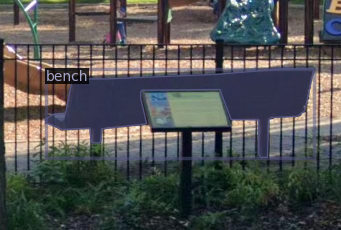

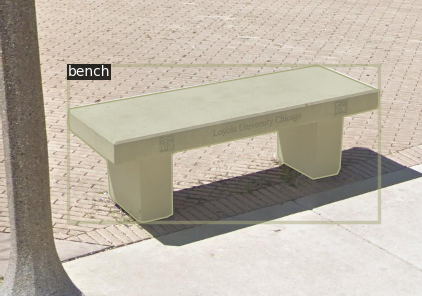

In [ ]:
DatasetCatalog.clear()
MetadataCatalog.clear()

city = "Chicago"
furniture = "Bench"

register_coco_instances("test", {}, f"ThreeCitiesVal/gt/{city}_{furniture}.v1i.coco/_annotations.coco.json", "")
datasetdict = DatasetCatalog.get("test")

mpl.rcParams['savefig.pad_inches'] = 0

# testing the model on the ground truth

for i, d in enumerate(random.sample(datasetdict, 2)):
    bench_metadata = MetadataCatalog.get("test")
    img = cv2.imread(f"ThreeCitiesVal/gt/{city}_{furniture}.v1i.coco/" + d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=bench_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    
    img = vis.get_image()[:, :, ::-1]
    
    display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

In [ ]:
# model_iters = ["0000999", "0001999", "0002999", "0003999", "0004999"]
model_iters = ["0001999"]

for modelType in ["output_bollard"]:
    cfg.OUTPUT_DIR = modelType
    for dir_name in ["ThreeCitiesVal/NYC_bollard","ThreeCitiesVal/Chicago_bollard","ThreeCitiesVal/Seattle_bollard"]:
        for model_iter in model_iters:
            cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, f"model_{model_iter}.pth")  # path to the model we just trained
            cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
            predictor = DefaultPredictor(cfg)
     
            fnames = glob(f"./{dir_name}/*.jpg")
            os.makedirs(f"{dir_name}-result-{cfg.OUTPUT_DIR}-{model_iter}", exist_ok=True)
            
            for f in fnames:
                out_name = os.path.basename(f)
                im = cv2.imread(f)
                ori_size = im.shape[:2]
                outputs = predictor(im)
                v = Visualizer(im[:, :, ::-1],
                               scale=1,
                               instance_mode=ColorMode.IMAGE_BW
                )
                out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
                im_arr = out.get_image()[:, :, ::-1]
                fin_im = im_arr
                cv2.imwrite(f"{dir_name}-result-{cfg.OUTPUT_DIR}-{model_iter}/" + out_name, fin_im)
        
                # save mask
                n = len(outputs["instances"])
                if n != 0:
                    a = np.array(outputs["instances"].to("cpu").pred_masks).transpose(1,2,0)
                    a = np.logical_or.reduce(a, axis=2)
                    mask = a
                    cv2.imwrite(f"{dir_name}-result-{cfg.OUTPUT_DIR}-{model_iter}/" + out_name.replace(".jpg",".png"), mask*1)
                else:
                    cv2.imwrite(f"{dir_name}-result-{cfg.OUTPUT_DIR}-{model_iter}/" + out_name.replace(".jpg",".png"), np.zeros(ori_size))

In [ ]:
city = "Seattle" # Seattle, NYC, or Chicago
furniture = "bollard" #bollard or bench
mType = "V" # V, R, or VR

gts = glob(f"./ThreeCitiesVal/gt/0_{city}_{furniture}_gt/*")
if furniture == "bench":
    preds = glob(f"./ThreeCitiesVal/pred/{city}_{furniture}-result-output_cocockpt_{mType}-{iter}/*.png")
else:
    preds = glob(f"./ThreeCitiesVal/pred/{city}_{furniture}-result-output_bollard-{iter}/*.png")

paccs = []

for gt_f, pred_f in zip(gts,preds):
    gt, pred = np.array(Image.open(gt_f)), np.array(Image.open(pred_f))
    paccs.append(pixel_accuracy(gt,pred))
    
ious = []
for gt_f, pred_f in zip(gts,preds):
    gt, pred = np.array(Image.open(gt_f)), np.array(Image.open(pred_f))
    intersection = np.logical_and(gt, pred)
    union = np.logical_or(gt, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append((iou_score,city))

pa = np.round(np.mean(paccs),3)
iou = np.round(np.mean(ious),3)
print("pa: {}, iou: {}".format(pa,iou))